In [2]:
import numpy as np
from pandas_datareader import data 
apple = data.DataReader('AFI.AX', 'yahoo', start='1/1/2010', end= '1/10/2015')
apple['Returns'] = apple['Adj Close'].pct_change()
# mu = apple['Returns'].mean()
# std = apple['Returns'].std()

def sample_data(n_samples=50000, seq_length=10):

    vectors = []

    for i in range(n_samples):
        daily_returns=np.random.normal(mu, std, seq_length)
        vectors.append(daily_returns)
    
    return np.asarray(vectors)

samples = sample_data()

In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv1D, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# MNIST dataset

x_train = sample_data(seq_length=20)
#x_train = x_train.reshape(50000, 20, 1)
original_dim = x_train.shape[1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 32
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
inputs2 = Reshape((original_dim, 1))(inputs)
x = Conv1D(filters=intermediate_dim, kernel_size=2, padding='same', activation='relu')(inputs2)
y = Dense(1, activation='relu')(x)
y = Reshape((20,))(y)
z_mean = Dense(latent_dim, name='z_mean')(y)
z_log_var = Dense(latent_dim, name='z_log_var')(y)
# #print(x.shape, y.shape)


# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
reshape_11 (Reshape)            (None, 20, 1)        0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 20, 32)       96          reshape_11[0][0]                 
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 20, 1)        33          conv1d_6[0][0]                   
____________________________________________________________________________________________

In [6]:
models = (encoder, decoder)
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

W0831 13:44:37.230824 4799972800 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 20)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 213       
_________________________________________________________________
decoder (Model)              (None, 20)                756       
Total params: 969
Trainable params: 969
Non-trainable params: 0
_________________________________________________________________


In [8]:
x_test = sample_data(10000, seq_length=20)
#x_test = x_test.reshape(10000, 20, 1)

In [9]:
x_test.shape, x_train.shape

((10000, 20), (50000, 20))

In [10]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

W0831 13:44:48.292050 4799972800 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.3711 - val_loss: 0.2395
Epoch 2/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.1910 - val_loss: 0.1704
Epoch 3/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.1655 - val_loss: 0.1618
Epoch 4/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.1608 - val_loss: 0.1593
Epoch 5/50
50000/50000 [==============================] - 1s 22us/step - loss: 0.1592 - val_loss: 0.1583
Epoch 6/50
50000/50000 [==============================] - 1s 23us/step - loss: 0.1585 - val_loss: 0.1578
Epoch 7/50
50000/50000 [==============================] - 1s 23us/step - loss: 0.1581 - val_loss: 0.1575
Epoch 8/50
50000/50000 [==============================] - 1s 23us/step - loss: 0.1580 - val_loss: 0.1574
Epoch 9/50
50000/50000 [==============================] - 1s 23us/step - loss: 0.1579 - val_loss: 0.1572
Epoch

In [12]:
from tqdm import tqdm

In [13]:
grid_x = np.linspace(-2, 2, 100)
grid_y = np.linspace(-2, 2, 100)[::-1]

gen_data = []
for i, yi in tqdm(enumerate(grid_y)):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        gen_data.append(x_decoded[0])
        #print(z_sample.shape)

gen_data = np.array(gen_data)

100it [00:05, 18.08it/s]


In [15]:
ids = np.random.choice(10000, 100)
def series_from_returns(start, returns):
    res = [start]
    for ret in returns:
        res.append(res[-1]*ret + res[-1])
    return res

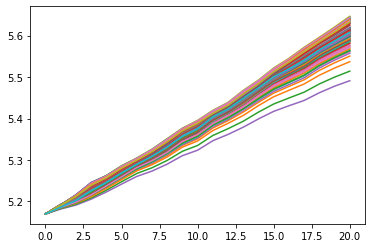

In [17]:
start = apple['Adj Close'][0]
for sample in gen_data[ids]:
    plt.plot(series_from_returns(start, sample))

In [18]:
np.mean(gen_data), np.std(gen_data)

(0.0040407237, 0.0006488779)

In [19]:
np.mean(samples), np.std(samples)

(0.003930798688825413, 0.0886432615963365)

In [20]:
from scipy import stats
p_value = np.mean([stats.normaltest(gen_data[i]).pvalue for i in ids])
print("Mean p_value", p_value)

Mean p_value 0.5878100536263432


# More Layers

In [63]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv1D, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# MNIST dataset

x_train = sample_data(seq_length=20)
#x_train = x_train.reshape(50000, 20, 1)
original_dim = x_train.shape[1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 32
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
inputs2 = Reshape((original_dim, 1))(inputs)
x = Conv1D(filters=intermediate_dim, kernel_size=2, padding='same', activation='relu')(inputs2)
x = Conv1D(filters=intermediate_dim*2, kernel_size=2, padding='same', activation='relu')(x)
y = Dense(1, activation='relu')(x)
y = Reshape((original_dim,))(y)
z_mean = Dense(latent_dim, name='z_mean')(y)
z_log_var = Dense(latent_dim, name='z_log_var')(y)
# #print(x.shape, y.shape)


# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
# y = Reshape((intermediate_dim, 1))(x)
# y = Conv1D(filters=intermediate_dim, kernel_size=2, padding='same', activation='relu')(y)
# y = Conv1D(filters=intermediate_dim*2, kernel_size=4, padding='same', activation='relu')(y)
# y = Dense(1, activation='relu')(y)
# w = Reshape((intermediate_dim,))(y)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
reshape_44 (Reshape)            (None, 20, 1)        0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 20, 32)       96          reshape_44[0][0]                 
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 20, 64)       4160        conv1d_32[0][0]                  
____________________________________________________________________________________________

In [64]:
models = (encoder, decoder)
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 20)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4405      
_________________________________________________________________
decoder (Model)              (None, 20)                756       
Total params: 5,161
Trainable params: 5,161
Non-trainable params: 0
_________________________________________________________________


In [65]:
x_test = sample_data(10000, seq_length=20)
#x_test = x_test.reshape(10000, 20, 1)

In [66]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.3707 - val_loss: 0.2327
Epoch 2/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.1874 - val_loss: 0.1689
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.1638 - val_loss: 0.1615
Epoch 4/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.1597 - val_loss: 0.1593
Epoch 5/50
50000/50000 [==============================] - 3s 50us/step - loss: 0.1584 - val_loss: 0.1585
Epoch 6/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.1578 - val_loss: 0.1582
Epoch 7/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.1575 - val_loss: 0.1579
Epoch 8/50
50000/50000 [==============================] - 2s 50us/step - loss: 0.1574 - val_loss: 0.1579
Epoch 9/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.1573 - val_loss: 0.1578
Epoch

In [67]:
grid_x = np.linspace(-0.1, 0.1, 100)
grid_y = np.linspace(-0.1, 0.1, 100)[::-1]

gen_data = []
for i, yi in tqdm(enumerate(grid_y)):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        gen_data.append(x_decoded[0])
        #print(z_sample.shape)

gen_data = np.array(gen_data)

100it [00:06, 15.05it/s]


In [68]:
ids = np.random.choice(10000, 100)
def series_from_returns(start, returns):
    res = [start]
    for ret in returns:
        res.append(res[-1]*ret + res[-1])
    return res

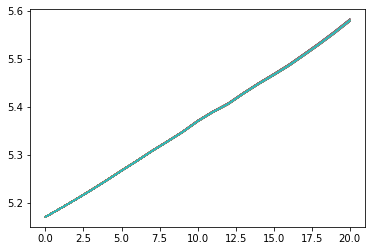

In [69]:
start = apple['Adj Close'][0]
for sample in gen_data[ids]:
    plt.plot(series_from_returns(start, sample))

In [70]:
np.mean(gen_data), np.std(gen_data)

(0.0038205015, 0.0003228459)

In [54]:
np.mean(x_train), np.std(x_train)

(0.003924794848461513, 0.08868587895511211)

In [71]:
from scipy import stats
p_value = np.mean([stats.normaltest(gen_data[i]).pvalue for i in ids])
print("Mean p_value", p_value)

Mean p_value 0.7766073603134507


In [42]:
from scipy import stats
p_value = np.mean([stats.normaltest(gen_data[i]).pvalue for i in ids])
print("Mean p_value", p_value)

Mean p_value 0.835393710913806


In [61]:
predicts = encoder.predict(x_train)
max([x[0] for x in predicts[0]]), min([x[0] for x in predicts[0]])

(5.461905e-05, 5.461905e-05)